In [1]:
import scipy.io
import keras
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestNeighbors

from proglearn.progressive_learner import ProgressiveLearner
from proglearn.deciders import SimpleArgmaxAverage
from proglearn.transformers import TreeClassificationTransformer, NeuralClassificationTransformer
from proglearn.voters import TreeClassificationVoter, KNNClassificationVoter

from joblib import Parallel, delayed
import time
from itertools import product
import pandas as pd

from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFBBBB', '#BBFFBB', '#BBBBFF'])
cmap_bold = ListedColormap(['#CC0000', '#00AA00', '#0000CC'])

In [2]:
def make_XOR(n_samples=100, cluster_center=[0,0], cluster_std=0.25, dist_from_center=0.5,
             N_XOR=False, theta_rotation=0, random_state=None):
    
    #variable setup
    seed = random_state
    dist = dist_from_center
    std = cluster_std
    n = int(n_samples/4)
    
    cluster_centers = np.array(list(product([dist, -dist], repeat=2)))
    cluster_centers = cluster_center - cluster_centers
    n_per_cluster = np.full(shape=2, fill_value=n)

    #make blobs
    X1,_ = datasets.make_blobs(n_samples=n_per_cluster, n_features=2, centers=cluster_centers[[0,3], :], 
                               cluster_std=std, random_state=seed)
    X2,_ = datasets.make_blobs(n_samples=n_per_cluster, n_features=2, centers=cluster_centers[[1,2], :], 
                               cluster_std=std, random_state=seed)
    
    #assign classe
    if N_XOR:
        y1, y2 = -np.ones(n*2), np.ones(n*2)
    else:
        y1, y2 = np.ones(n*2), -np.ones(n*2)

    X = np.concatenate((X1, X2))
    y = np.concatenate((y1, y2))

    #rotation
    c, s = np.cos(theta_rotation), np.sin(theta_rotation)
    R = np.array([[c, -s], [s, c]])
    X = (R @ X.T).T
    
    return X,y

In [3]:
def nearest_neighbor(src, dst):
    '''
    Find the nearest (Euclidean) neighbor in dst for each point in src
    Input:
        src: Nxm array of points
        dst: Nxm array of points
    Output:
        distances: Euclidean distances of the nearest neighbor
        indices: dst indices of the nearest neighbor
    '''

    assert src.shape == dst.shape

    neigh = NearestNeighbors(n_neighbors=1)
    neigh.fit(dst)
    distances, indices = neigh.kneighbors(src, return_distance=True)
    return distances.ravel(), indices.ravel()

In [4]:
def best_fit_transform(A, B):
    '''
    Calculates the least-squares best-fit transform that maps corresponding points A to B in m spatial dimensions
    Input:
      A: Nxm numpy array of corresponding points
      B: Nxm numpy array of corresponding points
    Returns:
      T: (m+1)x(m+1) homogeneous transformation matrix that maps A on to B
      R: mxm rotation matrix
      t: mx1 translation vector
    '''

    assert A.shape == B.shape

    # get number of dimensions
    m = A.shape[1]

    # translate points to their centroids
    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)
    AA = A - centroid_A
    BB = B - centroid_B

    # rotation matrix
    H = np.dot(AA.T, BB)
    U, S, Vt = np.linalg.svd(H)
    R = np.dot(Vt.T, U.T)

    # special reflection case
    if np.linalg.det(R) < 0:
        Vt[m-1,:] *= -1
        R = np.dot(Vt.T, U.T)

    # translation
    t = centroid_B.T - np.dot(R,centroid_A.T)

    # homogeneous transformation
    T = np.identity(m+1)
    T[:m, :m] = R
    T[:m, m] = t

    return T, R, t

In [106]:
def icp(A, B, init_pose=None, max_iterations=100, tolerance=1e-24):
    '''
    The Iterative Closest Point method: finds best-fit transform that maps points A on to points B
    Input:
        A: Nxm numpy array of source mD points
        B: Nxm numpy array of destination mD point
        init_pose: (m+1)x(m+1) homogeneous transformation
        max_iterations: exit algorithm after max_iterations
        tolerance: convergence criteria
    Output:
        T: final homogeneous transformation that maps A on to B
        distances: Euclidean distances (errors) of the nearest neighbor
        i: number of iterations to converge
    '''

    assert A.shape == B.shape

    # get number of dimensions
    m = A.shape[1]

    # make points homogeneous, copy them to maintain the originals
    src = np.ones((m+1,A.shape[0]))
    dst = np.ones((m+1,B.shape[0]))
    src[:m,:] = np.copy(A.T)
    dst[:m,:] = np.copy(B.T)

    # apply the initial pose estimation
    if init_pose is not None:
        src = np.dot(init_pose, src)

    prev_error = 0

    for i in range(max_iterations):
        # find the nearest neighbors between the current source and destination points
        distances, indices = nearest_neighbor(src[:m,:].T, dst[:m,:].T)

        # compute the transformation between the current source and nearest destination points
        T,_,_ = best_fit_transform(src[:m,:].T, dst[:m,indices].T)

        # update the current source
        src = np.dot(T, src)

        # check error
        mean_error = np.mean(distances)
        if np.abs(prev_error - mean_error) < tolerance:
            break
        prev_error = mean_error
        print(mean_error)

    # calculate final transformation
    T,_,_ = best_fit_transform(A, src[:m,:].T)

    return T, src, i

In [6]:
#Make XOR1 and 2
x1, y1 = make_XOR(n_samples=500)
x2, y2 = make_XOR(n_samples=500, theta_rotation=np.pi/3)

#Grid Setup for XOR1
h = 0.05 
X1 = x1.copy()
Y1 = y1.copy()
x1_min, x1_max = X1[:,0].min()-1, X1[:,0].max()+1 
y1_min, y1_max = X1[:,1].min()-1, X1[:,1].max()+1 
xx1, yy1 = np.meshgrid(np.arange(x1_min, x1_max, h), np.arange(y1_min, y1_max, h))
grid1 = np.c_[xx1.ravel(), yy1.ravel()]

#Grid Setup for XOR2
h = 0.05 
X2 = x2.copy()
Y2 = y2.copy()
x2_min, x2_max = X2[:,0].min()-1, X2[:,0].max()+1 
y2_min, y2_max = X2[:,1].min()-1, X2[:,1].max()+1 
xx2, yy2 = np.meshgrid(np.arange(x2_min, x2_max, h), np.arange(y2_min, y2_max, h))
grid2 = np.c_[xx2.ravel(), yy2.ravel()]

#Grid Setup for XOR3
h = 0.05 
T, X3, i = icp(x2.copy(), x1.copy())
X3 = X3.T[:,0:2]
print(i)
Y3 = y2.copy()
x3_min, x3_max = X3[:,0].min()-1, X3[:,0].max()+1 
y3_min, y3_max = X3[:,1].min()-1, X3[:,1].max()+1 
xx3, yy3 = np.meshgrid(np.arange(x3_min, x3_max, h), np.arange(y3_min, y3_max, h))
grid3 = np.c_[xx3.ravel(), yy3.ravel()]

#Predicting for XOR1
clf = RandomForestClassifier(n_estimators=500, max_depth=20)
ZZ1 = clf.fit(X1,Y1).predict(grid1)
ZZ1 = ZZ1.reshape(xx1.shape)

#Predicting for XOR2
clf = RandomForestClassifier(n_estimators=500, max_depth=20)
ZZ2 = clf.fit(X2,Y2).predict(grid2)
ZZ2 = ZZ2.reshape(xx2.shape)

clf = RandomForestClassifier(n_estimators=500, max_depth=20)
ZZ3 = clf.fit(X3,Y3).predict(grid3)
ZZ3 = ZZ3.reshape(xx3.shape)

108


<ipython-input-8-a5edd61cd751>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx1, yy1, ZZ1, cmap=cmap_light);
<ipython-input-8-a5edd61cd751>:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx2, yy2, ZZ2, cmap=cmap_light);
<ipython-input-8-a5edd61cd751>:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X 

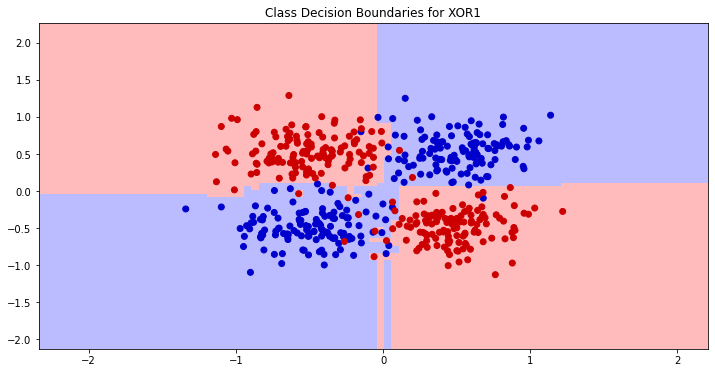

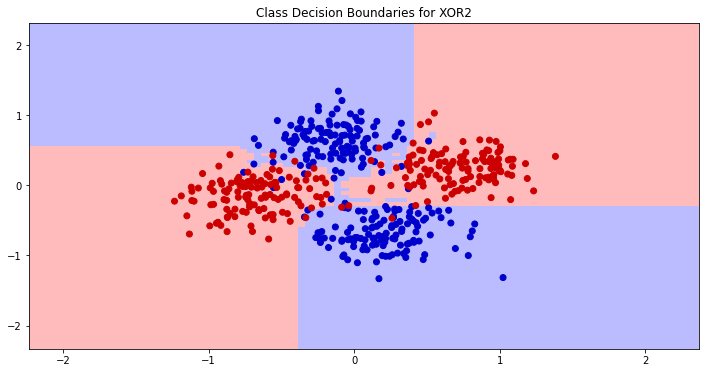

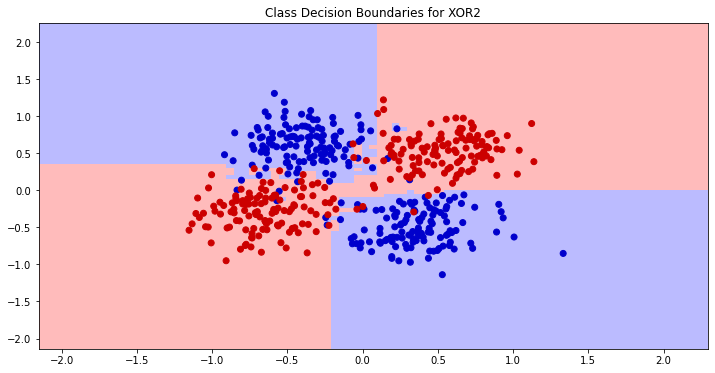

In [8]:
#Plot the decision boundary for XOR1
plt.figure(figsize=(12,6));
plt.pcolormesh(xx1, yy1, ZZ1, cmap=cmap_light);
plt.scatter(X1[:,0], X1[:,1], c=y1, cmap=cmap_bold);
plt.xlim(xx1.min(), xx1.max());
plt.ylim(yy1.min(), yy1.max());
plt.title('Class Decision Boundaries for XOR1');

#Plot the decision boundary for XOR2
plt.figure(figsize=(12,6));
plt.pcolormesh(xx2, yy2, ZZ2, cmap=cmap_light);
plt.scatter(X2[:,0], X2[:,1], c=y2, cmap=cmap_bold);
plt.xlim(xx2.min(), xx2.max());
plt.ylim(yy2.min(), yy2.max());
plt.title('Class Decision Boundaries for XOR2');

#Plot the decision boundary for XOR3
plt.figure(figsize=(12,6));
plt.pcolormesh(xx3, yy3, ZZ3, cmap=cmap_light);
plt.scatter(X3[:,0], X3[:,1], c=y2, cmap=cmap_bold);
plt.xlim(xx3.min(), xx3.max());
plt.ylim(yy3.min(), yy3.max());
plt.title('Class Decision Boundaries for XOR2');

In [136]:
import scipy.io
import keras
import numpy as np
import random
import matplotlib.pyplot as plt
from skimage import color, transform, img_as_ubyte, img_as_float
from scipy import ndimage
from skimage.transform import rotate

(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
data_x = np.concatenate([X_train, X_test])
data_y = np.concatenate([y_train, y_test]).reshape(-1)

In [137]:
def cross_val_data(data_x, data_y, total_cls=10):
    x = data_x.copy()
    y = data_y.copy()
    idx = [np.where(data_y == u)[0] for u in np.unique(data_y)]


    for i in range(total_cls):
        indx = idx[i]#np.roll(idx[i],(cv-1)*100)
        random.shuffle(indx)

        if i==0:
            train_x1 = x[indx[0:250],:]
            train_x2 = x[indx[250:500],:]
            train_y1 = y[indx[0:250]]
            train_y2 = y[indx[250:500]]

            test_x = x[indx[500:600],:]
            test_y = y[indx[500:600]]
        else:
            train_x1 = np.concatenate((train_x1, x[indx[0:250],:]), axis=0)
            train_x2 = np.concatenate((train_x2, x[indx[250:500],:]), axis=0)
            train_y1 = np.concatenate((train_y1, y[indx[0:250]]), axis=0)
            train_y2 = np.concatenate((train_y2, y[indx[250:500]]), axis=0)

            test_x = np.concatenate((test_x, x[indx[500:600],:]), axis=0)
            test_y = np.concatenate((test_y, y[indx[500:600]]), axis=0)


    return train_x1, train_y1, train_x2, train_y2, test_x, test_y

In [138]:
train_x1, train_y1, train_x2, train_y2, test_x, test_y = cross_val_data(data_x, data_y, total_cls=10)

In [139]:
angle = 30

#change data angle for second task
tmp_data = train_x2.copy()
total_data = tmp_data.shape[0]
original = []
rotated = []

for i in range(total_data):
    tmp = rotate(tmp_data[i], angle, resize=False)
    #plt.imshow(tmp)
    original.append(img_as_ubyte(train_x1[i]))
    rotated.append(img_as_ubyte(tmp))

In [140]:
tmp_data = np.stack(rotated)
train_x1 = np.stack(original)

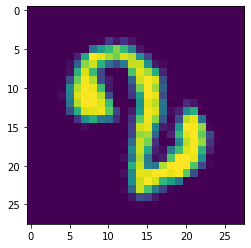

In [141]:
plt.imshow(tmp_data[500])

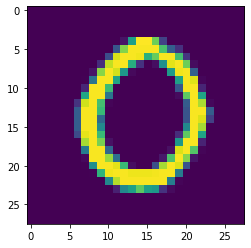

In [142]:
plt.imshow(train_x1[0])

In [143]:
train_x1 = train_x1.reshape((train_x1.shape[0], train_x1.shape[1] * train_x1.shape[2]))
tmp_data = tmp_data.reshape((tmp_data.shape[0], tmp_data.shape[1] * tmp_data.shape[2]))

In [144]:
T, transformed, i = icp(tmp_data.copy(), train_x1.copy())

1509.9886194824007
1356.8952988661304
1333.7991571179277
1321.9914957780206
1314.6932585588631
1309.0749436565875
1304.9462319582667
1302.273827540965
1300.1761927576945
1298.1924996294563
1296.5947721263256
1295.3111994992544
1294.1038954002142
1293.215051301931
1292.7487273384604
1292.2058920226564
1291.724312208252
1291.1628676991404
1290.8292127010031
1290.4157599285854
1289.9027945948562
1289.4286642889404
1289.1691763617248
1288.876019211333
1288.713675783047
1288.5791406636577
1288.4882332962475
1288.374260479157
1288.3026646476026
1288.2820837288343


In [145]:
post_regist = transformed[0:784,:]

In [146]:
reshaped_regist = np.reshape(post_regist, (2500, 28, 28))